# Выбор локации для скважины

## Введение
Необходимо решить задачу о финансировании одного из возможных регионов добычи нефти. 
Дано:
1. Данные по 100 000 скважинам из трех регионов для построения модели машинного обучения.
2. По каждой скважине есть три признака и значение запасов нефти.
3. Бюджет на разработку скважин 10 000 000 000 рублей.
4. Стоимость барреля нефти 450 рублей. (данные о количестве нефти в скважине представлены в тыс. баррелей).

Процесс принятия решения:
1. Предварительно разарабатываются 500 скважин, с которых собираются признаки.
2. С помощью модели машинного обучения выбираются 200 самых перспективных скважин. 
3. Скважины разрабатываются - нефть продается. 

Алгоритм решения задачи: 
1. Выполним предобработку данных.
2. Разделим выборки на тренировочную и валдиационную.
3. Обучим по модели для каждого региона. 
4. Рассчитаем прибыль техникой bootstrap для 500 случайных скважин в каждом регионе (выбрав далее 200 лучших по предсказаниям модели)
5. Найдем доверительный интервал прибыли для каждого региона.
6. Оценим вероятность возникновения убытков в регионе. 

## Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from matplotlib import pyplot as plt

In [2]:
max_points = 500 #количество исследуюмых точек выбранного региона
work_points = 200 #количество разрабатываемых точек
point_budget = 10**10 #бюджет на разработку скважины
revenue = 450000 #доход с одной единицы продукта

In [3]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
display(data_0.describe())
display(data_1.describe())
display(data_2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Разделим данные на признаки и целевой признак. Далее, разделим выборки на обучающие и валидационные.


Видим, что в разных признаки разные на уровне порядков разбросы данных. Во избежание присваивания некорректных весов признакам при обучении модели, выполним нормализацию значений признаков, методом `StandardScaler`.

In [8]:
features_0 = data_0.drop(columns = ['id', 'product'])
features_1 = data_1.drop(columns = ['id', 'product'])
features_2 = data_2.drop(columns = ['id', 'product'])

target_0 = data_0['product']
target_1 = data_1['product']
target_2 = data_2['product']

In [9]:
features_0_train, features_0_valid, target_0_train, target_0_valid = train_test_split(features_0, target_0, test_size= 0.25, random_state= 12345)
features_1_train, features_1_valid, target_1_train, target_1_valid = train_test_split(features_1, target_1, test_size= 0.25, random_state= 12345)
features_2_train, features_2_valid, target_2_train, target_2_valid = train_test_split(features_2, target_2, test_size= 0.25, random_state= 12345)

In [10]:
def scaler (features_train, features_valid):
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_valid = scaler.transform(features_valid)
    features_train = scaler.transform(features_train)
    return features_train, features_valid

In [11]:
features_0_train, features_0_valid = scaler(features_0_train, features_0_valid)
features_1_train, features_1_valid = scaler(features_1_train, features_1_valid)
features_2_train, features_2_valid = scaler(features_2_train, features_2_valid)

In [12]:
print ('Размер тренировочной выборки региона 0:',features_0_train.shape)
print ('Размер тренировочной выборки региона 1:',features_1_train.shape)
print ('Размер тренировочной выборки региона 2:',features_2_train.shape)
print ('Размер валидационной выборки региона 0:',features_0_valid.shape)
print ('Размер валидационной выборки региона 1:',features_1_valid.shape)
print ('Размер валидационной выборки региона 2:',features_2_valid.shape)

Размер тренировочной выборки региона 0: (75000, 3)
Размер тренировочной выборки региона 1: (75000, 3)
Размер тренировочной выборки региона 2: (75000, 3)
Размер валидационной выборки региона 0: (25000, 3)
Размер валидационной выборки региона 1: (25000, 3)
Размер валидационной выборки региона 2: (25000, 3)


#### Выводы. 
1. В нашем распоряжении данные по 100 000 скважинам из трех регионов. 
2. По каждой скважине в данных представлены три признака - f0, f1, f2 и объем запасов нефти в тысячах баррелей.
3. Данные по каждому региону разделены на валидационную и обучающую выборки.
4. Выполнено масштабирование признаков. 

## Обучение модели и проверка модели

Задача является задачей регрессии. В качестве модели будем использовать модель `LinearRegression`

In [13]:
# функция, создающая модель для каждого региона по тренировочным и валидационным выборкам
def predicted_oil(features_train, features_valid, target_train, target_valid):
    model = LinearRegression().fit(features_train, target_train)
    results = model.predict(features_valid)
    rmse = mean_squared_error(results ,target_valid)**0.5
    mean_product = results.mean()
    return mean_product, rmse, results

In [14]:
mean_product_0, rmse_0, results_0 = predicted_oil(features_0_train, features_0_valid, target_0_train, target_0_valid)
print ('Средний предсказанный запас нефти в регионе ноль:', mean_product_0, 'тыс. баррелей.')
print ('Средняя ошибка модели для региона:', rmse_0, 'тыс. баррелей.')

Средний предсказанный запас нефти в регионе ноль: 92.59256778438035 тыс. баррелей.
Средняя ошибка модели для региона: 37.5794217150813 тыс. баррелей.


In [15]:
mean_product_1, rmse_1, results_1 = predicted_oil(features_1_train, features_1_valid, target_1_train, target_1_valid)
print ('Средний предсказанный запас нефти в регионе один:', mean_product_1, 'тыс. баррелей.')
print ('Средняя ошибка модели для региона:', rmse_1, 'тыс. баррелей.')

Средний предсказанный запас нефти в регионе один: 68.728546895446 тыс. баррелей.
Средняя ошибка модели для региона: 0.893099286775617 тыс. баррелей.


In [16]:
mean_product_2, rmse_2, results_2 = predicted_oil(features_2_train, features_2_valid, target_2_train, target_2_valid)
print ('Средний предсказанный запас нефти в регионе два:', mean_product_2, 'тыс. баррелей.')
print ('Средняя ошибка модели для региона:', rmse_2, 'тыс. баррелей.')

Средний предсказанный запас нефти в регионе два: 94.96504596800489 тыс. баррелей.
Средняя ошибка модели для региона: 40.02970873393434 тыс. баррелей.


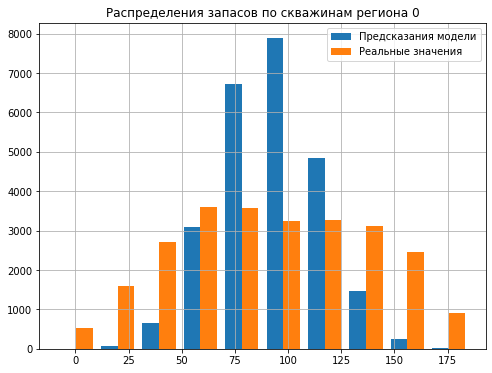

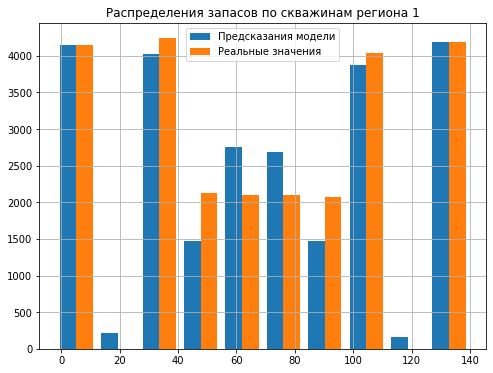

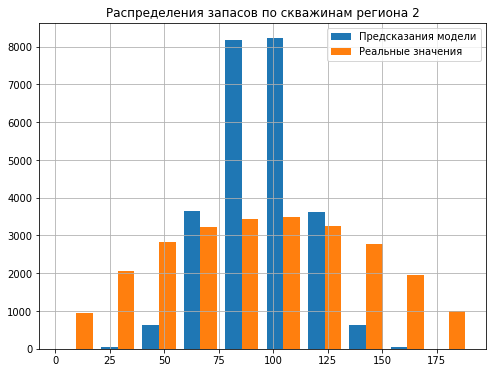

In [17]:
#Гистограмма для региона 0
plt.figure(figsize= (8,6))
plt.title('Распределения запасов по скважинам региона 0')
plt.grid()
plt.hist([results_0,target_0_valid], label=['Предсказания модели', 'Реальные значения'])
plt.legend()
plt.show()


#Гистограмма для региона 1
plt.figure(figsize= (8,6))
plt.title('Распределения запасов по скважинам региона 1')
plt.grid()
plt.hist([results_1,target_1_valid], label=['Предсказания модели', 'Реальные значения'])
plt.legend()
plt.show()


#Гистограмма для региона 2
plt.figure(figsize= (8,6))
plt.title('Распределения запасов по скважинам региона 2')
plt.grid()
plt.hist([results_2,target_2_valid], label=['Предсказания модели', 'Реальные значения'])
plt.legend()
plt.show()

#### Выводы
Модель для каждого регона обучена.

Самые большие средние запасы нефти предсказаны в регионе номер два, но этому же региону соответвует наименее качественно обученная модель, средняя ошибка составляет порядка 40 тыс баррелей на скважину. 

Наиболее релевантно модель обучена для региона номер один, средняя ошибка составляет 0.89 тыс баррелей на скважину. Средний объем запасов составляет 68.7 тыс баррелей нефти на скважину. 

## Подготовка к расчету прибыли

Сохраним все константные значения, необходимые для расчета прибыли. 

Рассчитаем минимальное необходимое среднее количество нефти.

Найдем его как отношение бюджета на разработку всех скважин к выручкке с тысячи баррелей и количеству разрабатываемых скважин.

In [18]:
min_product = point_budget/revenue/200
min_product

111.11111111111111

### Вывод
Минимальное среднее значение сырья для каждого региона превышает среднее значение сырья, предсказанное моделями. 
Найдем средние значения предсказанного сырья для топ-200 скважин по предсказанным запасам. 

In [19]:
results_0 = pd.Series(results_0, index=target_0_valid.index)
top_wells_0 = results_0.sort_values(ascending = False).head(work_points-1).index
product_predict_0 = results_0[top_wells_0]
product_real_0 = target_0_valid[top_wells_0]

region_0_stats = pd.concat([results_0, target_0_valid], axis =1)
region_0_stats.columns = ['predicted', 'real']

print ('среднее значение региона_0, предсказанное моделью:', product_predict_0.mean())
print ('среднее значение региона_0 на самом деле:', product_real_0.mean())

среднее значение региона_0, предсказанное моделью: 155.54756230056083
среднее значение региона_0 на самом деле: 148.15047934986757


In [20]:
results_1 = pd.Series(results_1, index = target_1_valid.index)
top_wells_1 = results_1.sort_values(ascending = False).head(work_points-1).index
product_predict_1 = results_1[top_wells_1]
product_real_1 = target_1_valid[top_wells_1]

region_1_stats = pd.concat([results_1, target_1_valid], axis =1)
region_1_stats.columns = ['predicted', 'real']

print ('среднее значение региона 1, предсказанное моделью', product_predict_1.mean())
print ('среднее значение региона 1 на самом деле', product_real_1.mean())

среднее значение региона 1, предсказанное моделью 138.73173912274706
среднее значение региона 1 на самом деле 137.94540774090612


In [21]:
results_2 = pd.Series(results_2, index = target_2_valid.index)
top_wells_2 = results_2.sort_values(ascending = False).head(work_points).index
product_predict_2 = results_2[top_wells_2]
product_real_2 = target_2_valid[top_wells_2]

region_2_stats = pd.concat([results_2, target_2_valid], axis =1)
region_2_stats.columns = ['predicted', 'real']

print ('среднее значение региона 2, предсказанное моделью', product_predict_2.mean())
print ('среднее значение региона 2 на самом деле', product_real_2.mean())

среднее значение региона 2, предсказанное моделью 148.01949329159194
среднее значение региона 2 на самом деле 141.22611070666485


Видим, что на отобранных 200 точках с максимальным прогнозируемым объемом сырья, среднее значение сырья выше точки безубыточности. Составим функцию для расчета доходности региона с учетом того, **что 500 точек для машинного обучения выбираются случайным образом (в условии задачи так написано, но я не уверен).**

Доходность рассчитаем, как объем реальных запасов нефти на выбранных скважинах, умноженный на стоимость 1000 баррелей за вычетом расходов на разработку скважин.

In [22]:
# Функиця расчета прибыли
def profit_value(region_stats):
    sample = region_stats.sample(n=max_points, random_state =12345, replace = True)
    top_wells_product = sample.sort_values(by = 'predicted', ascending = False).head(work_points)['real'].sum()
    total_revenue = top_wells_product*revenue
    profit = total_revenue - point_budget  
    return int(profit/1000000)
print('region_0:',profit_value(region_0_stats), 'млн.р.')
print('region_1:',profit_value(region_1_stats), 'млн.р.')
print('region_2:',profit_value(region_2_stats), 'млн.р.')

region_0: 605 млн.р.
region_1: 228 млн.р.
region_2: -71 млн.р.


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 

1. Исправил на констнтное значение = 200. Запутался, думал, что head принимает на вход индексы, хотя если подумать чуть серьезнее, становится понятно, что это не так. 
    
2. Исправил replace на true.
</div>

Видим, что в случайно выбранных 500 точках, с дальнейшей сортировкой с помощью модели машинного обучения, наибольшая прибыль возможна в регионе 1. 

Найдем среднее значение прибыли в каждом регионе методом bootstrap.

In [23]:
def bootstrap(product):
    profits = []
    state = np.random.RandomState(12345)
    for i in range(1000):
        sub_sample = product.sample(frac =1, replace = False, random_state=state)
        profit = profit_value(sub_sample)
        profits.append(profit)
    return profits
profits_bootstrap_0 = pd.Series(bootstrap(region_0_stats))
profits_bootstrap_1 = pd.Series(bootstrap(region_1_stats))
profits_bootstrap_2 = pd.Series(bootstrap(region_2_stats))
print('Регион 0 средняя прибыль по итогам bootstrap:',profits_bootstrap_0.mean(), 'млн.р.')
print('Регион 1 средняя прибыль по итогам bootstrap:',profits_bootstrap_1.mean(), 'млн.р.')
print('Регион 2 средняя прибыль по итогам bootstrap:',profits_bootstrap_2.mean(), 'млн.р.')

Регион 0 средняя прибыль по итогам bootstrap: 376.211 млн.р.
Регион 1 средняя прибыль по итогам bootstrap: 452.36 млн.р.
Регион 2 средняя прибыль по итогам bootstrap: 403.96 млн.р.


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 

Здесь заменил возвращение на false. Если я правильно понял работу sample, то сейчас мы берем все 25 000 строк валидационной выборки и передаем в функцию для расчета прибыли для отбора 500 случайных с возвращением. 

Вопросы: 
1. Нужен ли тогда вообще метод sample здесь? Опять же, если я все правильно понимаю, мы как будто перетасовали колоду карт. 
2. Оказывает ли в этом случае какое-то влияние параметр random state?
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера :</b> 
    
Раз ты решил проводить семплирование в формуле, то здесь тогда уже не нужно, потому что сейчас да, получается он просто перемешивает все наблюдения. Но обрати внимание: если сейчас ты удалишь здесь перетасовку, то у тебя каждый раз будут отбираться одни и те же 500 строк, так как ты зафиксировал для них числовой random state. Чтобы этого не происходило, нужно задать его через `state = np.random.RandomState(12345)` и передавать в sample уже переменную state. Дело в том, что np.random.RandomState() заранее определяет список случайных значений, и каждый раз, когда какая-то функция обращается к этому списку случайностей, ей выдается следующее по очереди неиспользованное значение, то сеть если мы один раз зададим этот список и будем несколько раз обращаться к нему через sample, то у нас не будут получаться одни и те же выборки, так как при каждом следующем обращении к переменной state мы будем получать другое случайное значение.
    
    
Поскольку строки все-таки перемешиваются, то random state важен. Если мы оставим здесь семплирования (перемешивание полной выборки), то без зафиксированного random state оно каждый раз будет отличаться, и random state для отбора 500 точек (при условии, что он задан правильно, про это я рассказала в абзаце выше) уже не спасет (т.к. ему на вход каждый раз поступает разный порядок наблюдений), поэтому мы будем получать разные финальные результаты. 

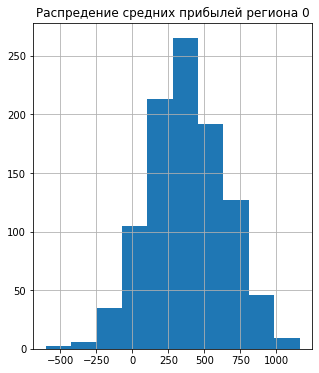

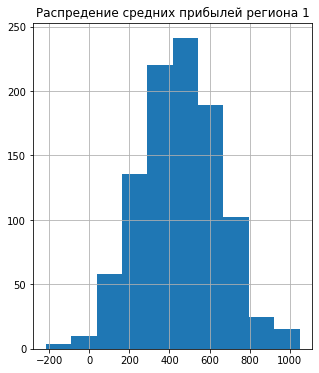

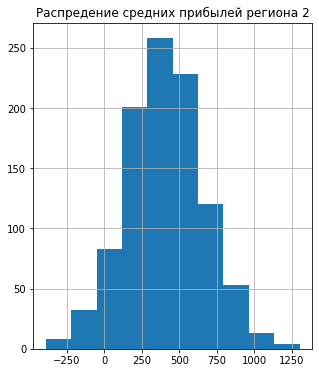

In [24]:
plt.figure()
plt.title('Распредение средних прибылей региона 0')
profits_bootstrap_0.hist(figsize = (5,6))
plt.show()

plt.figure()
plt.title('Распредение средних прибылей региона 1')
profits_bootstrap_1.hist(figsize = (5,6))
plt.show()


plt.figure()
plt.title('Распредение средних прибылей региона 2')
profits_bootstrap_2.hist(figsize = (5,6))
plt.show()

Рассчитаем доверительный интервал для средней прибыли выборок

In [25]:
print ('Регион 0, 95% доверительный интервал от:',
       profits_bootstrap_0.quantile(0.05),
       'млн. р.',
       'до:',
       profits_bootstrap_0.quantile(0.95),
      'млн. р.')

print ('Регион 1, 95% доверительный интервал от:',
       profits_bootstrap_1.quantile(0.05),
       'млн. р.',
       'до:',
       profits_bootstrap_1.quantile(0.95),
      'млн. р.')

print ('Регион 2, 95% доверительный интервал от:',
       profits_bootstrap_2.quantile(0.05),
       'млн. р.',
       'до:',
       profits_bootstrap_2.quantile(0.95),
      'млн. р.')

Регион 0, 95% доверительный интервал от: -56.099999999999994 млн. р. до: 818.05 млн. р.
Регион 1, 95% доверительный интервал от: 129.9 млн. р. до: 780.0 млн. р.
Регион 2, 95% доверительный интервал от: -32.0 млн. р. до: 858.1499999999999 млн. р.


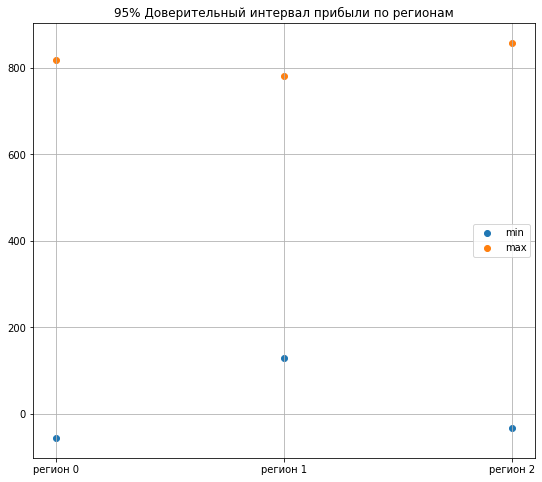

In [26]:
left = [profits_bootstrap_0.quantile(0.05), profits_bootstrap_1.quantile(0.05), profits_bootstrap_2.quantile(0.05)]
right = [profits_bootstrap_0.quantile(0.95), profits_bootstrap_1.quantile(0.95), profits_bootstrap_2.quantile(0.95)]
regions = ['регион 0', 'регион 1', 'регион 2']
plt.figure(figsize = (9,8))
plt.title('95% Доверительный интервал прибыли по регионам')
plt.grid()
plt.scatter(regions,left)
plt.scatter(regions, right)
plt.legend(['min', 'max'])
plt.show()

#### Выводы
1. После применения техники bootstrap наиболее прибыльным регоном оказался регион один. 
2. По итогам расчета доверительного интервала в регионе ноль и регионе два, левая граница интервала - отрицательная, в регионе номер один левая граница интервала составляет 129.9 млн р.
3. Правая граница 95% доверительного интервала наибольшая в регионе два, далее регион ноль, далее регион один. Разница между регонами по правой границе в пределах 5%, то есть незначительная. 

Рассчитаем риски убытков по регонам

## Расчет рисков

Найдем вероятность убытков, как отношение количества средних прибылей меньше нуля к количетсву исходов больше нуля

In [27]:
print ('вероятность убытков в регионе 0:', (profits_bootstrap_0 < 0).mean()*100, '%')
print ('вероятность убытков в регионе 1:', (profits_bootstrap_1 < 0).mean()*100, '%')
print ('вероятность убытков в регионе 2:', (profits_bootstrap_2 < 0).mean()*100, '%')

вероятность убытков в регионе 0: 7.3 %
вероятность убытков в регионе 1: 1.3 %
вероятность убытков в регионе 2: 6.800000000000001 %


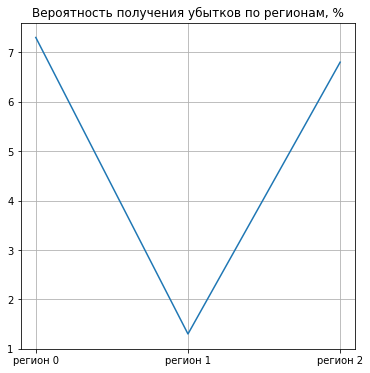

In [28]:
losses = [sum(profits_bootstrap_0<0)/len(profits_bootstrap_0)*100, sum(profits_bootstrap_1<0)/len(profits_bootstrap_1)*100, sum(profits_bootstrap_2<0)/len(profits_bootstrap_2)*100]
plt.figure(figsize = (6,6))
plt.title('Вероятность получения убытков по регионам, %')
plt.grid()
plt.plot(regions, losses)
plt.show()

#### Выводы
Видим, что риск убытков в регионе один - минимальный, 1.3%. В регионе ноль риск убытков составляет 6.8%, в регионе два 7,3%

## Вывод
#### Предобработка данных
В нашем распоряжении оказались данные по 100 000 скважинам из трех регионов. 
Для каждого региона были выполнены следующие действия:
1. Проверена полнота данных
2. Разделение выборки на тренировочную и валидационную в пропорциях 25 на 75. 
3. Масштабирование признаков.

#### Обучение моделей
В качестве модели обучения выбор сделан в пользу "LinearRegression", так как на нашем объеме данных она дает наиболее предсказуемые результаты. 
Наиболее качественная по результатам модель получилась для региона один, где ошибка составила мене 1 тыс. баррелей на скважину. Сравнимыми по качеству получились модели для регионов ноль и два, где средняя ошибка составила более 30 тыс. баррелей на скважину. Это, предположительно, связано с тем, что по собираемым метрикам со скважин в регионе невозможно точно предсказать залежи нефти в скважине.  


#### Расчет прибыли и рисков, рекомендация по выбору региона
Для каждого региона техникой bootstrap были отобраны слуайным образом по 500 скважин, далее из них выбраны 200 лучших с помощью модели машинного обучения. Далее, по выбранным скважинам была рассчитана прибыль. Количество повторений - 1000. 

По итогам, был посчитан 95% доверительный интервал для каждого региона и риск получения убытков. Лучшие показатели получились в **регионе один** доверительный интервал составил 75 - 750 млн. р., риск получения убытков в регионе 1.3%. 

Остальные два региона имеют отрицательную левую границу доверительного интервала и риск убыточности более 5%